# Demystifying Gaussian Process Regression

Let's generate some fake, one dimensional data, which we'll fit with various techniques.

First we need to import matplotlib and numpy, the only two dependencies for this notebook: 

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Now let's generate a small dataset of observations $y$, observed at times $x$:

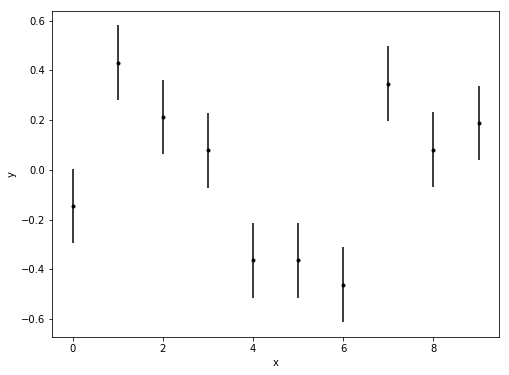

In [22]:
np.random.seed(42)
ndim = 10
x = np.arange(ndim)[:, np.newaxis]
y = np.random.rand(ndim)[:, None]
y -= y.mean()
x = np.arange(len(y))[:, None]
yerr = y.std() / 2 * np.ones_like(x)

plt.figure(figsize=(8, 6))
plt.errorbar(x, y, yerr, fmt='.', color='k')
plt.xlabel('x')
plt.ylabel('y');

***

# Linear regression

Solutions to the [ordinary least squares](https://en.wikipedia.org/wiki/Ordinary_least_squares) estimators $\hat{\beta}$ are

$$ \hat{\beta} = ({\bf X}^\top {\bf N}^{-1} {\bf X})^{-1} {\bf X}^\top {\bf N}^{-1} y,$$

and their uncertainties are given by

$$ \mathrm{cov} = {\bf X}^\top {\bf N}^{-1} {\bf X}, $$

where ${\bf N}$ is the matrix of uncertainties on measurements $y$ (${\bf N}$ is diagonal for measurements with independent Gaussian uncertainties, in this case). 

In [23]:
# Append a column of ones next to the `x` values using `np.vander`: 
X = np.vander(x.ravel(), 2)
inv_N = np.linalg.inv(np.identity(len(x)) * yerr**2)

# Solve linear regression: 
betas = np.linalg.inv(X.T @ inv_N @ X) @ X.T @ inv_N @ y
cov = np.linalg.inv(X.T @ inv_N @ X)

# Compute best fit line: 
best_fit = X @ betas 
err = np.sqrt(np.diag(cov))

Plot the result and its uncertainty (here we're plotting just the uncertainty in the intercept and ignoring the uncertainty in the slope, for this example)

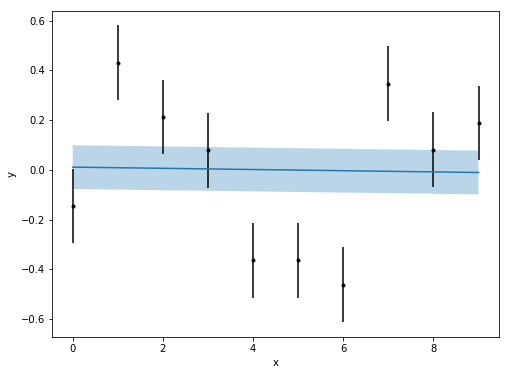

In [24]:
plt.figure(figsize=(8, 6))
plt.errorbar(x, y, yerr, fmt='.', color='k')
plt.plot(x, best_fit)
plt.fill_between(x.ravel(), best_fit.ravel()-err[1], best_fit.ravel()+err[1], alpha=0.3)
plt.xlabel('x')
plt.ylabel('y');

*** 
# Gaussian process regression

Gaussian process regression, in this example, is a technique for interpolating between observations or predicting the values of observations at a given time. The linear algebra this time looks a little more complicated, but it's a similar process:   

We define a "**kernel function**"

$$ {\bf K}({\bf x_1}, {\bf x_2}) = \sigma^2 \exp\left(-\frac{(x_1 - x_2)^2)}{2 \ell^2}\right)   $$

A **kernel function** describes the correlation between neighboring points. To start, we're using "squared exponential" kernel, which equivalent to saying "the correlation between neighboring points is defined by a Gaussian with two parameters, $\sigma$ and $\ell$." We call the tunable parameters within the kernel function **hyperparameters**.  

### The $\ell$ hyperparameter 
The $\ell$ parameter sets the autocorrelation timescale, in other words, how far two points need to be from each other in $x$ (time) before they are no longer correlated. If $\ell$ is large, distant points become more correlated, or in other words, the function becomes smoother. If $\ell$ is small, the function varies more rapidly with $x$. 


### Gaussian Process Regression
From [Rasmussen and Williams (2006)](http://www.gaussianprocess.org/gpml/), the predicted mean is (Equation 2.25) 

$$ \mu = {\bf k_*}^\top ({\bf K} + \sigma_n {\bf I})^{-1} {\bf y},  $$

and the covariance is (Equation 2.26)

$$ \mathrm{cov} = {\bf k}({\bf x_*}, {\bf x_*})- {\bf k_*}^\top ({\bf K }+ \sigma_n {\bf I})^{-1} {\bf k_*}, $$ 

and therefore the error on the predictions will be

$$ \mathrm{err} = \mathrm{diag}\left( \sqrt{\mathrm{cov}} \right).$$

In [33]:
def square_distance(x1, x2): 
    """
    Compute the squared distance between two vectors `x1` and `x2` 
    
    Note that (x1 - x2)^2 = x1^2 + x2^2 - 2 * x1 * x2, so we can use the short syntax below
    to avoid loops: 
    
    For reference, see: 
    https://medium.com/dataholiks-distillery/l2-distance-matrix-vectorization-trick-26aa3247ac6c
    """
    return np.sum(x1**2, axis=1)[:, np.newaxis] + np.sum(x2**2, axis=1) - 2 * np.dot(x1, x2.T)

def sq_exp_kernel(x1, x2, sigma=2, ell=1): 
    """
    Gaussian Kernel function
    """
    sqdist = square_distance(x1, x2)

    return sigma**2 * np.exp(-0.5 * sqdist / ell**2)

def gaussian_process_regression(x, y, yerr, xtest, kernel): 
    """
    Gaussian process regression for column vectors `x` and `y` with 
    uncertainties `yerr`; predict values at `xtest` using `kernel`
    """
    K = kernel(x, x) + np.identity(len(x)) * yerr**2
    k_s = kernel(x, xtest)
    k_ss = kernel(xtest, xtest)
    inv_K = np.linalg.inv(K)
    # The `@` operator in python 3 is the matrix multiplication operator
    mu = k_s.T @ inv_K @ y
    cov = k_ss - k_s.T @ inv_K @ k_s
    return mu, cov

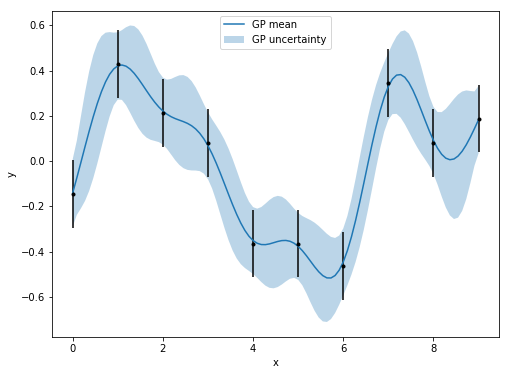

In [34]:
N = 100
xtest = np.linspace(x.min(), x.max(), N)[:, np.newaxis]

mu, cov = gaussian_process_regression(x, y, yerr, xtest, sq_exp_kernel)

err = np.sqrt(np.diagonal(cov))

plt.figure(figsize=(8, 6))
plt.errorbar(x, y, yerr, fmt='.', color='k')
plt.plot(xtest.ravel(), mu.ravel(), label='GP mean')
plt.fill_between(xtest.ravel(), mu.ravel()-err, mu.ravel()+err, alpha=0.3, label='GP uncertainty')
plt.legend(loc='upper center')
plt.xlabel('x')
plt.ylabel('y');

In the figure above, the blue line shows the predicted value of $y$ for values of $x$ where there were no observations – that's why we say Gaussian process regression is a form of interpolation. It's essentially interpolating between points, where the smoothness of the interpolation is set by the kernel function. 

But Gaussian process regression is more powerful than just predicting the value of $y$ for arbitrary $x$, it also computes the uncertainty of prediction at for arbitrary $x$. The blue region in the figure above shows the uncertainty on the predicted value of $y$ at each $x$. Note that the uncertainty is equivalent to the width of the error bars where there are observations, and the uncertainty gets larger in between observations. 

### Square-Exponential (Gaussian) Kernel

which allows you to vary the $\ell$ hyperparameter and see the results: 

In [27]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [28]:
def gp_interact(ell):
    def sq_exp_kernel_interactive(x1, x2, sigma=1, ell=ell): 
        """
        Interactive Gaussian Kernel function
        """
        sqdist = square_distance(x1, x2)

        return sigma**2 * np.exp(-0.5 * sqdist / ell**2)
    
    mu, cov = gaussian_process_regression(x, y, yerr, xtest, sq_exp_kernel_interactive)
    err = np.sqrt(np.diag(cov))
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].errorbar(x, y, yerr, fmt='.', color='k')
    ax[0].plot(xtest.ravel(), mu.ravel(), label='GP Mean')
    ax[0].fill_between(xtest.ravel(),  mu.ravel()-err, mu.ravel()+err, alpha=0.2, label='GP Uncertainty')
    ax[0].set(xlabel='$x$', ylabel='$y$', title='GP Regression')
    ax[0].legend(loc='upper center')
    
    ax[1].set(xlabel='$x_1$', ylabel='$x_2$', title='Covariance matrix')
    ax[1].imshow(sq_exp_kernel_interactive(x, x))
    
    plt.show()

print('Vary the hyperparameter "ell", which defines the autocorrelation timescale:')
interactive_plot = interactive(gp_interact, ell=(1, 10, 1))
output = interactive_plot.children[-1]
interactive_plot

Vary the hyperparameter "ell", which defines the autocorrelation timescale:


interactive(children=(IntSlider(value=5, description='ell', max=10, min=1), Output()), _dom_classes=('widget-interact',))

### Exponential-cosine kernel 

In [29]:
def gp_interact(ell, period):
    def exp_cos(x1, x2, sigma=1, ell=ell, period=period): 
        """
        Interactive Gaussian Kernel function
        """
        sqdist = square_distance(x1, x2)

        return sigma**2 * np.exp(-0.5 * sqdist / ell**2) * np.cos(2*np.pi*np.sqrt(sqdist)/period)
    
    mu, cov = gaussian_process_regression(x, y, yerr, xtest, exp_cos)
    err = np.sqrt(np.diag(cov))
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].errorbar(x, y, yerr, fmt='.', color='k')
    ax[0].plot(xtest.ravel(), mu.ravel(), label='GP Mean')
    ax[0].fill_between(xtest.ravel(),  mu.ravel()-err, mu.ravel()+err, alpha=0.2, label='GP Uncertainty')
    ax[0].set(xlabel='$x$', ylabel='$y$', title='GP Regression')
    ax[0].legend(loc='upper center')
    
    ax[1].set(xlabel='$x_1$', ylabel='$x_2$', title='Covariance matrix')
    ax[1].imshow(exp_cos(x, x))
    
    plt.show()

print('Vary the hyperparameters "ell" and "period", which define the autocorrelation timescale:')
interactive_plot = interactive(gp_interact, ell=(1, 10, 1), period=(1, 10, 1))
output = interactive_plot.children[-1]
interactive_plot

Vary the hyperparameters "ell" and "period", which define the autocorrelation timescale:


interactive(children=(IntSlider(value=5, description='ell', max=10, min=1), IntSlider(value=5, description='period', max=10, min=1), Output()), _dom_classes=('widget-interact',))